In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
import matplotlib.pyplot as plt


In [3]:

batch_size = 64


In [4]:

train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=5, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [6]:

model = Net()
optimizer = Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()


In [7]:

epochs = 1
for epoch in range(epochs):
    losses = 0
    i = 0
    for x, y in train_loader:

        y_hat = model(x)

        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses += loss.item()
        i += 1

    print(f'Epoch: {epoch}, loss: {losses / i}')



Epoch: 0, loss: 0.5220138697640728


In [8]:

i = 0
acc = 0

for x_test, y_test in test_loader:

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)

    y_argmax = y_pred.argmax(1)

    acc += len(torch.nonzero(y_argmax == y_test)) / len(y_test)
    i += 1

print(f'accuracy = {acc / i}')


accuracy = 0.9685999999999966


In [9]:

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


In [21]:

def test(epsilon=0):

    acc = 0
    i = 0

    for x, y in test_loader:

        x.requires_grad_()

        y_hat = model(x)
        init_pred = y_hat.argmax(1)

        loss = F.nll_loss(y_hat, y)
        model.zero_grad()
        loss.backward()

        perturbed_data = fgsm_attack(x, epsilon, x.grad.data)

        y_hat_fake = model(perturbed_data)
        final_pred = y_hat_fake.argmax(1)

        if i == 0:
            print(f'Epsilon: {epsilon}')

            for j in range(len(x)):
                print(f'{j+1}. Real: {y[j]}, Prediction: {init_pred[j]}, Perturbed: {final_pred[j]}')
                plt.imshow(perturbed_data[j].detach().numpy()[0], cmap='gray')
                plt.show()

        acc += len(torch.nonzero(final_pred == y)) / len(y)
        i += 1

    print(f'Accuracy: {acc / i}')
    return acc / i


In [22]:

epsilons = (0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0)
accuracies = []


Epsilon: 0.0
1. Real: 7, Prediction: 7, Perturbed: 7


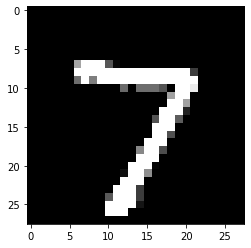

2. Real: 2, Prediction: 2, Perturbed: 2


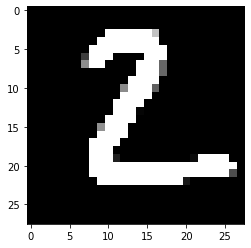

3. Real: 1, Prediction: 1, Perturbed: 1


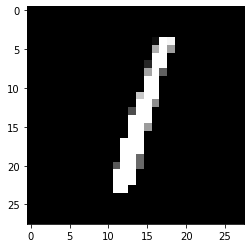

4. Real: 0, Prediction: 0, Perturbed: 0


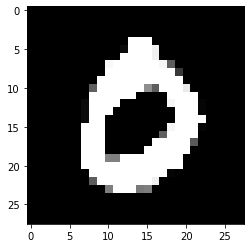

5. Real: 4, Prediction: 4, Perturbed: 4


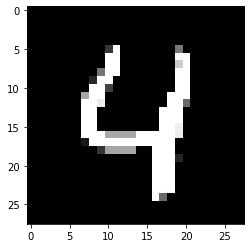

Accuracy: 0.957899999999995
Epsilon: 0.1
1. Real: 7, Prediction: 7, Perturbed: 7


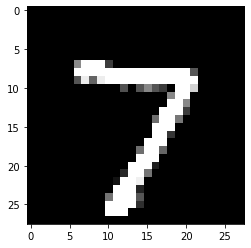

2. Real: 2, Prediction: 2, Perturbed: 2


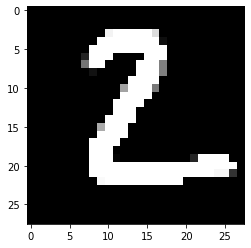

3. Real: 1, Prediction: 1, Perturbed: 1


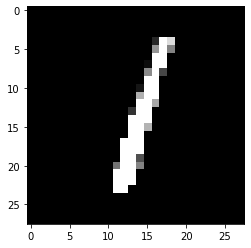

4. Real: 0, Prediction: 0, Perturbed: 0


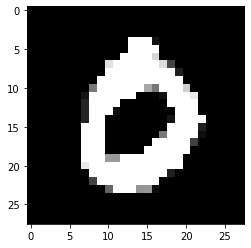

5. Real: 4, Prediction: 4, Perturbed: 4


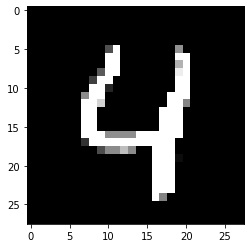

Accuracy: 0.9503999999999946
Epsilon: 0.3
1. Real: 7, Prediction: 7, Perturbed: 7


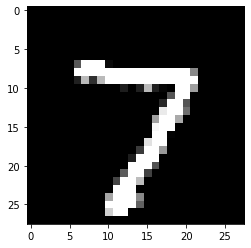

2. Real: 2, Prediction: 2, Perturbed: 2


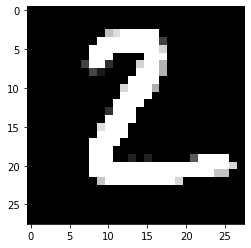

3. Real: 1, Prediction: 1, Perturbed: 1


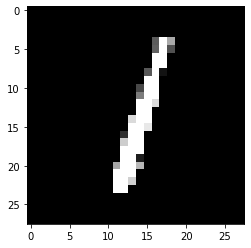

4. Real: 0, Prediction: 0, Perturbed: 0


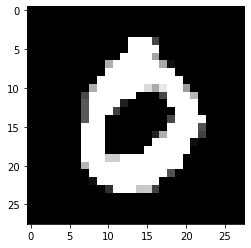

5. Real: 4, Prediction: 4, Perturbed: 4


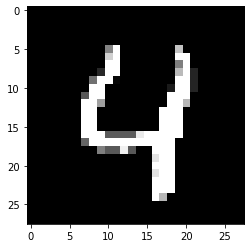

Accuracy: 0.9310999999999928
Epsilon: 0.5
1. Real: 7, Prediction: 7, Perturbed: 7


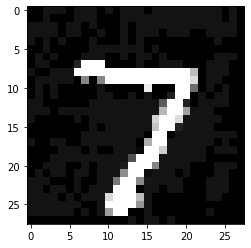

2. Real: 2, Prediction: 2, Perturbed: 2


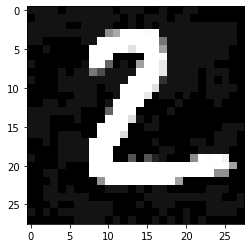

3. Real: 1, Prediction: 1, Perturbed: 1


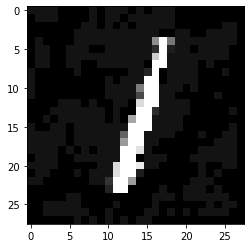

4. Real: 0, Prediction: 0, Perturbed: 0


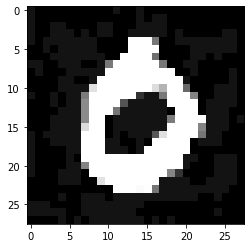

5. Real: 4, Prediction: 4, Perturbed: 4


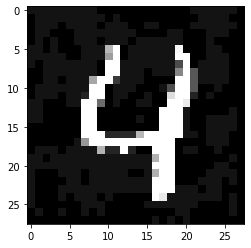

Accuracy: 0.8441999999999903
Epsilon: 0.7
1. Real: 7, Prediction: 7, Perturbed: 7


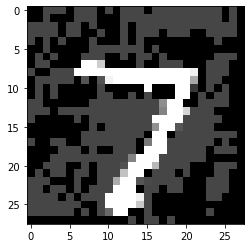

2. Real: 2, Prediction: 2, Perturbed: 0


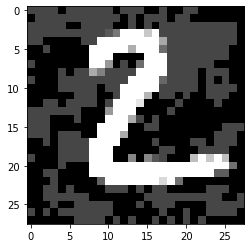

3. Real: 1, Prediction: 1, Perturbed: 1


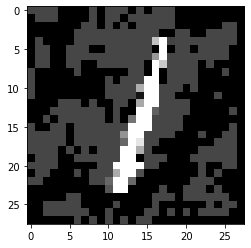

4. Real: 0, Prediction: 0, Perturbed: 0


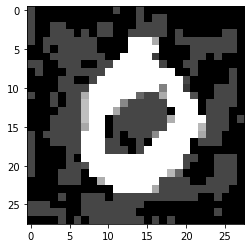

5. Real: 4, Prediction: 4, Perturbed: 9


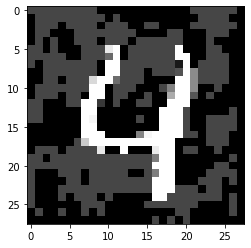

Accuracy: 0.4796999999999988
Epsilon: 0.9
1. Real: 7, Prediction: 7, Perturbed: 7


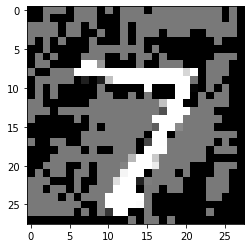

2. Real: 2, Prediction: 2, Perturbed: 0


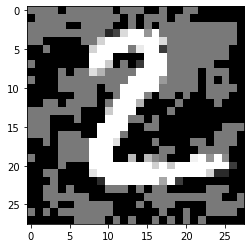

3. Real: 1, Prediction: 1, Perturbed: 2


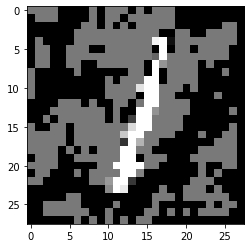

4. Real: 0, Prediction: 0, Perturbed: 0


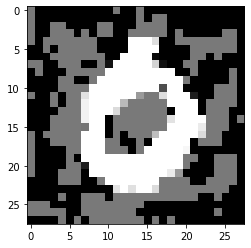

5. Real: 4, Prediction: 4, Perturbed: 2


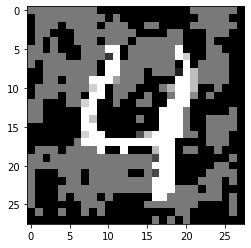

Accuracy: 0.188499999999997
Epsilon: 1.0
1. Real: 7, Prediction: 7, Perturbed: 2


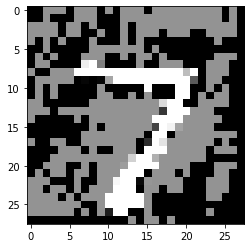

2. Real: 2, Prediction: 2, Perturbed: 0


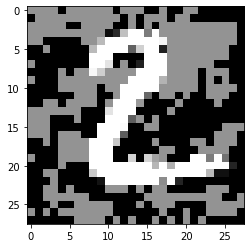

3. Real: 1, Prediction: 1, Perturbed: 2


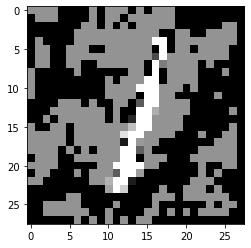

4. Real: 0, Prediction: 0, Perturbed: 0


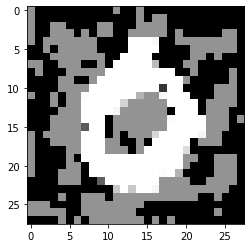

5. Real: 4, Prediction: 4, Perturbed: 2


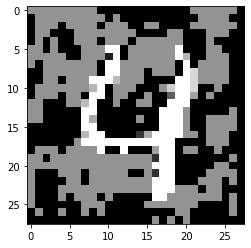

Accuracy: 0.11009999999999928


[0.957899999999995,
 0.9503999999999946,
 0.9310999999999928,
 0.8441999999999903,
 0.4796999999999988,
 0.188499999999997,
 0.11009999999999928]

In [23]:

for e in epsilons:
    accuracies.append(test(e))
accuracies


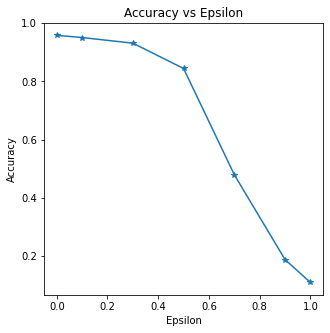

In [24]:

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
#plt.yticks(np.arange(0, 1.1, step=0.1))
#plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


In [36]:

def bim_attack(x, y, n_iter=10, epsilon=0.15, epsilon_iter=0.01, clip_min=-1, clip_max=1):
    model.eval()
    x.requires_grad_()
    eta = torch.zeros(x.shape)

    for i in range(n_iter):
        out = model(x+eta)
        loss = F.cross_entropy(out, y)
        loss.backward()

        eta += epsilon_iter * torch.sign(x.grad.data)
        eta.clamp_(-epsilon, epsilon)
        x.grad.data.zero_()

    x_adv = x + eta
    x_adv.clamp_(clip_min, clip_max)

    return x_adv


In [55]:

def test_bim(epsilon=0, epsilon_iter=0, iter=10):

    acc = 0
    i = 0

    for x, y in test_loader:

        model.eval()
        with torch.no_grad():
            y_hat = model(x)
        init_pred = y_hat.argmax(1)

        x_adv = bim_attack(x, y, iter, epsilon, epsilon_iter)
        model.eval()
        with torch.no_grad():
            y_hat = model(x_adv)
        final_pred = y_hat.argmax(1)

        if i == 0:
            print(f'Epsilon: {epsilon}\tEpisonIter: {epsilon_iter}')

            for j in range(len(x)):
                print(f'{j+1}. Real: {y[j]}, Prediction: {init_pred[j]}, Perturbed: {final_pred[j]}')
                plt.imshow(x_adv[j].detach().numpy()[0], cmap='gray')
                plt.show()

        acc += len(torch.nonzero(final_pred == y)) / len(y)
        i += 1

        break

    acc /= i
    print(acc)
    return acc


In [56]:

epsilon = 0.5
epsilon_iters = [0.0, 0.005, 0.01, 0.015, 0.02, 0.03]
iter = 20


Epsilon: 0.5	EpisonIter: 0.0
1. Real: 7, Prediction: 7, Perturbed: 7


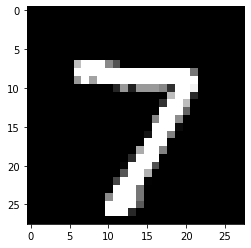

2. Real: 2, Prediction: 2, Perturbed: 2


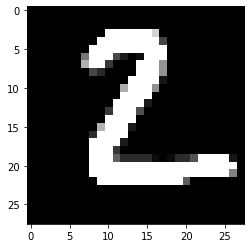

3. Real: 1, Prediction: 1, Perturbed: 1


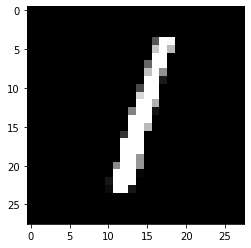

4. Real: 0, Prediction: 0, Perturbed: 0


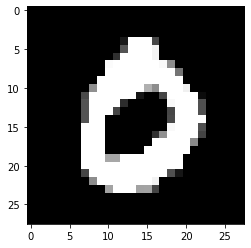

5. Real: 4, Prediction: 4, Perturbed: 4


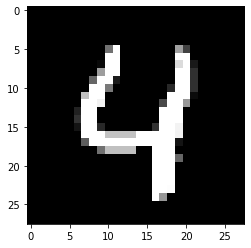

1.0
Epsilon: 0.5	EpisonIter: 0.005
1. Real: 7, Prediction: 7, Perturbed: 7


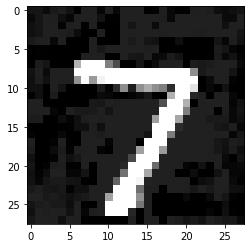

2. Real: 2, Prediction: 2, Perturbed: 2


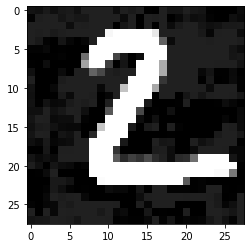

3. Real: 1, Prediction: 1, Perturbed: 1


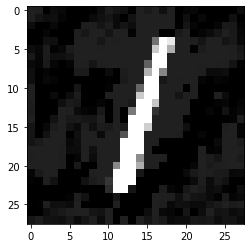

4. Real: 0, Prediction: 0, Perturbed: 0


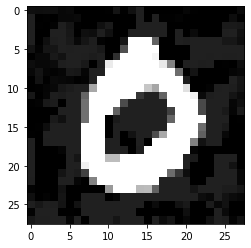

5. Real: 4, Prediction: 4, Perturbed: 4


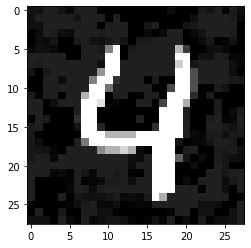

1.0
Epsilon: 0.5	EpisonIter: 0.01
1. Real: 7, Prediction: 7, Perturbed: 7


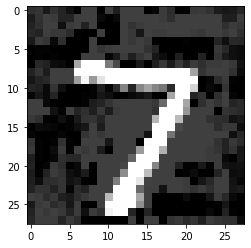

2. Real: 2, Prediction: 2, Perturbed: 0


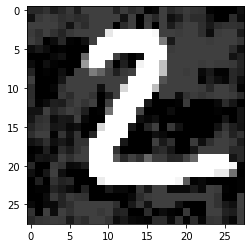

3. Real: 1, Prediction: 1, Perturbed: 1


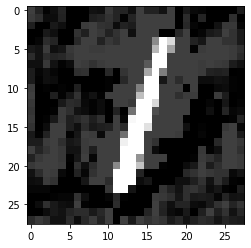

4. Real: 0, Prediction: 0, Perturbed: 0


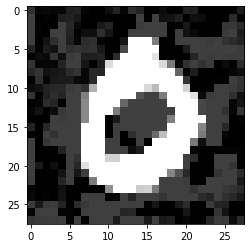

5. Real: 4, Prediction: 4, Perturbed: 4


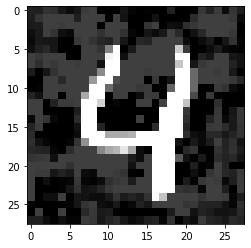

0.8
Epsilon: 0.5	EpisonIter: 0.015
1. Real: 7, Prediction: 7, Perturbed: 7


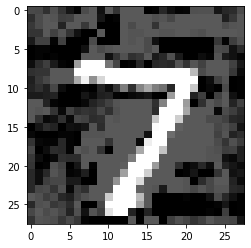

2. Real: 2, Prediction: 2, Perturbed: 0


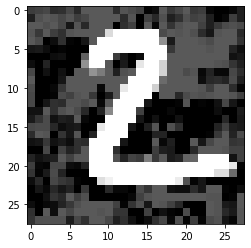

3. Real: 1, Prediction: 1, Perturbed: 1


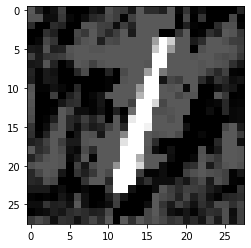

4. Real: 0, Prediction: 0, Perturbed: 0


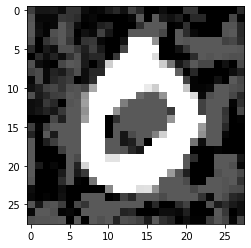

5. Real: 4, Prediction: 4, Perturbed: 9


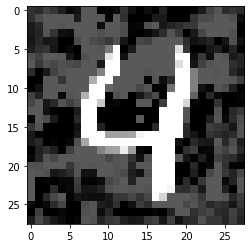

0.6
Epsilon: 0.5	EpisonIter: 0.02
1. Real: 7, Prediction: 7, Perturbed: 7


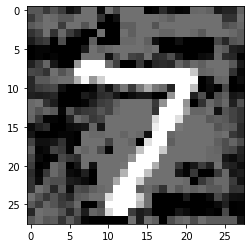

2. Real: 2, Prediction: 2, Perturbed: 0


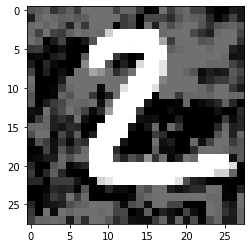

3. Real: 1, Prediction: 1, Perturbed: 7


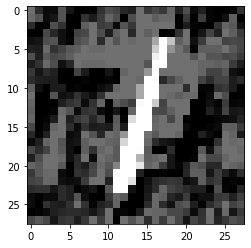

4. Real: 0, Prediction: 0, Perturbed: 0


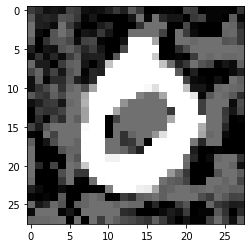

5. Real: 4, Prediction: 4, Perturbed: 9


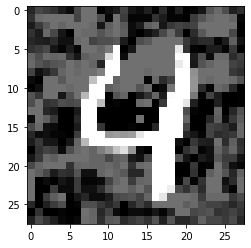

0.4
Epsilon: 0.5	EpisonIter: 0.03
1. Real: 7, Prediction: 7, Perturbed: 2


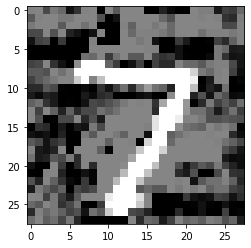

2. Real: 2, Prediction: 2, Perturbed: 0


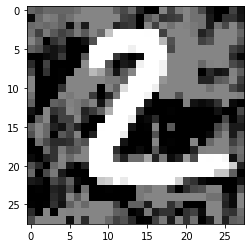

3. Real: 1, Prediction: 1, Perturbed: 7


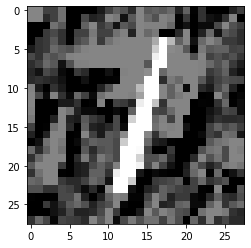

4. Real: 0, Prediction: 0, Perturbed: 5


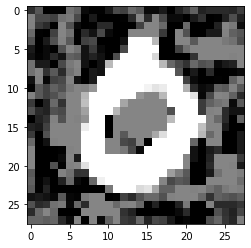

5. Real: 4, Prediction: 4, Perturbed: 9


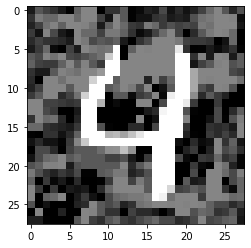

0.0


In [57]:

accuracies = []
for eps_itr in epsilon_iters:
    accuracies.append(test_bim(epsilon, eps_itr, iter))



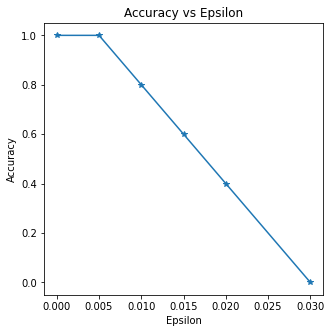

In [58]:

plt.figure(figsize=(5,5))
plt.plot(epsilon_iters, accuracies, "*-")
#plt.yticks(np.arange(0, 1.1, step=0.1))
#plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()
